# Locally simultaneous inference on climate data

We apply locally simultaneous inference to climate data from WeatherBench [1]. We use the ClimateLearn package [2] to access the data. The dataset contains hourly measurements of temperature across a discrete grid of locations on Earth. The grid is obtained by pairing 32 latitude coordinates with 64 longitude coordinates.

[1] Rasp, S., Dueben, P. D., Scher, S., Weyn, J. A., Mouatadid, S., & Thuerey, N. (2020). WeatherBench: A Benchmark Data Set for Data‐Driven Weather Forecasting. Journal of Advances in Modeling Earth Systems, 12(11).

[2] Nguyen, T., Jewik, J., Bansal, H., Sharma, P., Grover, A. (2023). ClimateLearn: Benchmarking Machine Learning for Weather and Climate Modeling. arXiv preprint.

In [1]:
%load_ext autoreload
%autoreload 2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from climate_learn.data import download
import scipy.stats as stats
import matplotlib.patheffects as pe
from climate_learn.utils.data import load_dataset, view

from methods import *
from utils import *

/Users/tijanazrnic/miniconda3/envs/lsi/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data processing

In [2]:
# Make cache
cache = './.cache'
os.makedirs(cache, exist_ok=True)
# Download data
#download(root = cache, source = "weatherbench", variable = "2m_temperature", dataset = "era5", resolution = "5.625")
dataset = load_dataset(cache + "/data/weatherbench/era5/5.625/2m_temperature")
view(dataset)

<xarray.Dataset>
Dimensions:  (lon: 64, lat: 32, time: 350640)
Coordinates:
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * time     (time) datetime64[ns] 1979-01-01 ... 2018-12-31T23:00:00
Data variables:
    t2m      (time, lat, lon) float32 dask.array<chunksize=(8760, 32, 64), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2019-11-07 07:51:20 GMT by grib_to_netcdf-2.14.0: /opt/ecmw...

In [3]:
df = dataset.to_dataframe()
temps = df.groupby(["time"]).mean()
times = temps.reset_index()["time"].to_numpy().astype(str)
idx = np.bitwise_not(np.array(["-02-29" in x for x in times]))
temps_proc = temps[idx]
samples_per_year = 365*24
samples = [ temps_proc[year*samples_per_year:(year+1)*samples_per_year].to_numpy() for year in range(0, int(temps_proc.shape[0]/samples_per_year)) ]

# Inference on the warmest days

We perform at inference on the single warmest day in the year and all days where the temperature exceeds a high enough threshold. Inference on the coldest days is done analogously. We take one measurement per day, at noon.

In [4]:
# split data into two chunks (for inference and covariance estimation)
n_cov = 20
n = len(samples) - n_cov

avg_temp = np.stack(samples[n_cov:], axis=0).mean(axis=0)
std_temp = np.stack(samples[:n_cov], axis=0).std(axis=0)

# take one measurement per day (at noon). this code finds the right indices
daily_idx = np.linspace(11,8771,366)
daily_idx = [int(daily_idx[i]) for i in range(len(daily_idx) - 1)]

avg_temp_daily = avg_temp[daily_idx]
std_temp_daily = std_temp[daily_idx]

Sigma = np.cov(np.stack([samples[i][daily_idx] for i in range(n_cov)], axis=0).squeeze().T)

m = len(avg_temp_daily)

## Inference on the single warmest day

In [5]:
alpha = 0.1
nu = 0.01 # for LSI
beta = 0.01 # for hybrid

selected_ind = np.argmax(avg_temp_daily)
max_temp = avg_temp_daily[selected_ind]

# simultaneous inference
SI_quantile = max_z_width(Sigma, alpha)
simultaneous_halfwidth = SI_quantile*std_temp_daily[selected_ind]/np.sqrt(n)
simultaneous_int = [max_temp - simultaneous_halfwidth, max_temp + simultaneous_halfwidth]

# locally simultaneous inference
plausible_gap = 4*max_z_width(Sigma, nu)*std_temp_daily/np.sqrt(n)
thresh = np.max(avg_temp_daily) - plausible_gap
plausible_inds = np.where(avg_temp_daily > thresh)[0]
Sigma_plausible = Sigma[np.ix_(plausible_inds, plausible_inds)]
LSI_quantile = max_z_width(Sigma_plausible, alpha-nu)
local_halfwidth = LSI_quantile*std_temp_daily[selected_ind]/np.sqrt(n)
local_int = [max_temp - local_halfwidth, max_temp + local_halfwidth]

# conditional inference
A, b = inference_on_winner_polyhedron(m, selected_ind)
eta = np.zeros(m)
eta[selected_ind] = 1
cond_int = conditional_inference(avg_temp_daily, 1/n*Sigma, A, b, eta, alpha=alpha)

# hybrid intervals
hybrid_int = hybrid_inference(avg_temp_daily, 1/n*Sigma, A, b, eta, alpha=alpha, beta=beta)

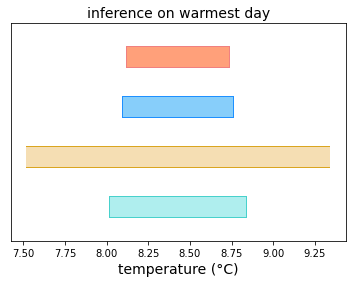

In [6]:
plot_title = 'inference on warmest day'
make_interval(local_int, simultaneous_int, cond_int, hybrid_int, plot_title, to_celsius = True, legend=False)
path = 'iow_warmestday.pdf'
plt.savefig(path, bbox_inches='tight')

## Inference on several warmest days

In [7]:
alpha = 0.1
nu = 0.01 # for LSI
beta = 0.01 # for hybrid

T = 281
selected_inds = np.where(avg_temp_daily > T)[0]

local_ints = []
simultaneous_ints = []
cond_ints = [[],[]]
hybrid_ints = [[],[]]

# simultaneous inference
SI_quantile = max_z_width(Sigma, alpha)
SI_halfwidth = SI_quantile*std_temp_daily[selected_inds]/np.sqrt(n)
simultaneous_ints = [avg_temp_daily[selected_inds] - SI_halfwidth, avg_temp_daily[selected_inds] + SI_halfwidth]

# locally simultaneous inference
plausible_gap = 2*max_z_width(Sigma, nu)*std_temp_daily/np.sqrt(n)
thresh = T - plausible_gap
plausible_inds = np.where(avg_temp_daily > thresh)[0]
Sigma_plausible = Sigma[np.ix_(plausible_inds, plausible_inds)]
LSI_quantile = max_z_width(Sigma_plausible, alpha-nu)
LSI_halfwidth = LSI_quantile*std_temp_daily[selected_inds]/np.sqrt(n)
local_ints = [avg_temp_daily[selected_inds] - LSI_halfwidth, avg_temp_daily[selected_inds] + LSI_halfwidth]


A, b = filedrawer_polyhedron(m, selected_inds, T)
for sel in selected_inds[:3]:
    eta = np.zeros(m)
    eta[sel] = 1
    
    # conditional inference
    cond_int = conditional_inference(avg_temp_daily, 1/n*Sigma, A, b, eta, alpha=alpha/len(selected_inds))
    cond_ints[0].append(cond_int[0])
    cond_ints[1].append(cond_int[1])

    # hybrid intervals
    hybrid_int = hybrid_inference(avg_temp_daily, 1/n*Sigma, A, b, eta, alpha=alpha/len(selected_inds), beta=beta)
    hybrid_ints[0].append(hybrid_int[0])
    hybrid_ints[1].append(hybrid_int[1])

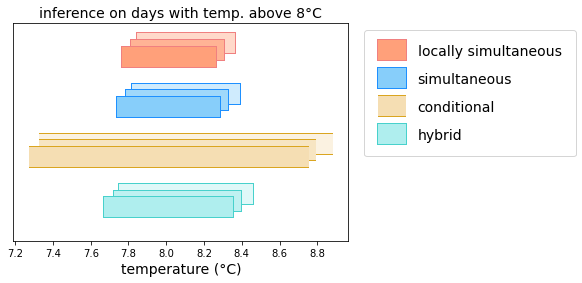

In [8]:
plot_title = 'inference on days with temp. above 8°C'
make_multiple_intervals(local_ints, simultaneous_ints, cond_ints, hybrid_ints, plot_title, to_celsius = True, legend=True)
path = 'filedrawer_warmestdays.pdf'
plt.savefig(path, bbox_inches='tight')

# Inference on the warmest locations

We perform at inference on the single warmest location in the grid and all locations where the temperature exceeds a high enough threshold. Inference on the coldest locations is done analogously. We compute the average annual temperature per location.

In [9]:
dt_index = df.index.get_level_values(2)
df["year"] = dt_index.year
df.set_index("year", append=True)
yearly_temp_latlong = df.groupby(["lat", "lon", "year"]).mean().reset_index()
numpy_temps = yearly_temp_latlong[yearly_temp_latlong["year"] <= 1998].to_numpy()
years = range(1979, 1999)

In [10]:
n_cov = 20
n = len(samples) - n_cov
Sigma_data = np.zeros((2048, n_cov))
for i in range(20):
    indices = np.where(numpy_temps[:,2] == years[i])
    Sigma_data[:,i] = numpy_temps[indices,3]
Sigma = np.cov(Sigma_data)

mean_temps = yearly_temp_latlong[yearly_temp_latlong["year"] > 1998].set_index("year").groupby(["lat", "lon"]).mean().reset_index()
std_temps = yearly_temp_latlong[yearly_temp_latlong["year"] <= 1998].set_index("year").groupby(["lat", "lon"]).std()
lat = mean_temps["lat"].to_numpy()
lon = mean_temps["lon"].to_numpy()
mean_temps = mean_temps["t2m"].to_numpy()
std_temps = std_temps.to_numpy().squeeze()
m = len(mean_temps)

## Inference on the single warmest location

In [11]:
alpha = 0.1
nu = 0.01 # for LSI
beta = 0.01 # for hybrid

selected_ind = np.argmax(mean_temps)
max_temp = mean_temps[selected_ind]

# simultaneous inference
SI_quantile = max_z_width(Sigma, alpha)
simultaneous_halfwidth = SI_quantile*std_temps[selected_ind]/np.sqrt(n)
simultaneous_int = [max_temp - simultaneous_halfwidth, max_temp + simultaneous_halfwidth]

# locally simultaneous inference
plausible_gap = 4*max_z_width(Sigma, nu)*std_temps/np.sqrt(n)
thresh = np.max(mean_temps) - plausible_gap
plausible_inds = np.where(mean_temps > thresh)[0]
Sigma_plausible = Sigma[np.ix_(plausible_inds, plausible_inds)]
LSI_quantile = max_z_width(Sigma_plausible, alpha-nu)
local_halfwidth = LSI_quantile*std_temps[selected_ind]/np.sqrt(n)
local_int = [max_temp - local_halfwidth, max_temp + local_halfwidth]

# conditional inference
A, b = inference_on_winner_polyhedron(m, selected_ind)
eta = np.zeros(m)
eta[selected_ind] = 1
cond_int = conditional_inference(mean_temps, 1/n*Sigma, A, b, eta, alpha=alpha)

# hybrid intervals
hybrid_int = hybrid_inference(mean_temps, 1/n*Sigma, A, b, eta, alpha=alpha, beta=beta)

/Users/tijanazrnic/Code/lsi/methods.py:49: RuntimeWarning: invalid value encountered in double_scalars
  if num/denom < 1-alpha/2:


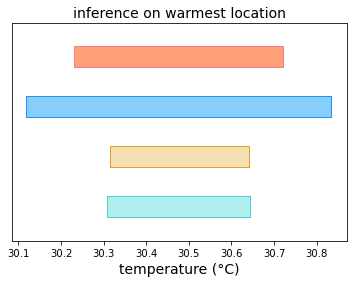

In [12]:
plot_title = 'inference on warmest location'
make_interval(local_int, simultaneous_int, cond_int, hybrid_int, plot_title, to_celsius = True, legend=False)
path = 'iow_warmestlocation.pdf'
plt.savefig(path, bbox_inches='tight')

## Inference on several warmest locations

In [13]:
alpha = 0.1
nu = 0.01 # for LSI
beta = 0.01 # for hybrid

T = 301
selected_inds = np.where(mean_temps > T)[0]

local_ints = []
simultaneous_ints = []
cond_ints = [[],[]]
hybrid_ints = [[],[]]

# simultaneous inference
SI_quantile = max_z_width(Sigma, alpha)
SI_halfwidth = SI_quantile*std_temps[selected_inds]/np.sqrt(n)
simultaneous_ints = [mean_temps[selected_inds] - SI_halfwidth, mean_temps[selected_inds] + SI_halfwidth]

# locally simultaneous inference
plausible_gap = 2*max_z_width(Sigma, nu)*std_temps/np.sqrt(n)
thresh = T - plausible_gap
plausible_inds = np.where(mean_temps > thresh)[0]
Sigma_plausible = Sigma[np.ix_(plausible_inds, plausible_inds)]
LSI_quantile = max_z_width(Sigma_plausible, alpha-nu)
LSI_halfwidth = LSI_quantile*std_temps[selected_inds]/np.sqrt(n)
local_ints = [mean_temps[selected_inds] - LSI_halfwidth, mean_temps[selected_inds] + LSI_halfwidth]


A, b = filedrawer_polyhedron(m, selected_inds, T)
for sel in selected_inds[:3]:
    eta = np.zeros(m)
    eta[sel] = 1
    
    # conditional inference
    cond_int = conditional_inference(mean_temps, 1/n*Sigma, A, b, eta, alpha=alpha/len(selected_inds))
    cond_ints[0].append(cond_int[0])
    cond_ints[1].append(cond_int[1])

    # hybrid intervals
    hybrid_int = hybrid_inference(mean_temps, 1/n*Sigma, A, b, eta, alpha=alpha/len(selected_inds), beta=beta)
    hybrid_ints[0].append(hybrid_int[0])
    hybrid_ints[1].append(hybrid_int[1])

/Users/tijanazrnic/Code/lsi/methods.py:49: RuntimeWarning: invalid value encountered in double_scalars
  if num/denom < 1-alpha/2:


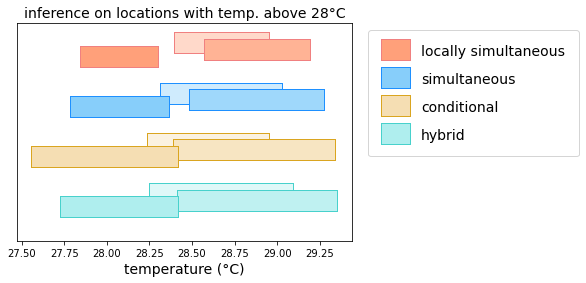

In [14]:
plot_title = 'inference on locations with temp. above 28°C'
make_multiple_intervals(local_ints, simultaneous_ints, cond_ints, hybrid_ints, plot_title, to_celsius = True, legend=True)
path = 'filedrawer_warmestlocations.pdf'
plt.savefig(path, bbox_inches='tight')